In [ ]:
# ==========================================================
# BLOCCO 1: Lettura dataset salvati
# ==========================================================
import pandas as pd
import joblib
import os

output_folder = "model_data"

# Carica dataset se non lo hai già
X_train = pd.read_parquet(os.path.join(output_folder, "X_autoencoder.parquet"))
y_train = pd.read_csv(os.path.join(output_folder, "y_multiclass.csv")).squeeze()

# Cartella dei dati salvati
data_folder = "model_data"

# 1️⃣ Lettura train/test set
X_train = pd.read_csv(os.path.join(data_folder, "X_train_balanced.csv"))
X_test  = pd.read_csv(os.path.join(data_folder, "X_test_balanced.csv"))
y_train = pd.read_csv(os.path.join(data_folder, "y_train_balanced.csv")).squeeze()
y_test  = pd.read_csv(os.path.join(data_folder, "y_test_balanced.csv")).squeeze()

# 2️⃣ Lettura scaler (opzionale se serve per nuovi dati)
scaler_latent = joblib.load(os.path.join(data_folder, "scaler_latent.pkl"))

# 3️⃣ Controllo dimensioni e classi
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts()}")
print(f"y_test distribution:\n{y_test.value_counts()}")


X_train: (38448, 16), X_test: (9612, 16)
y_train distribution:
label_tactic_reduced
Resource Development    12816
Reconnaissance          12816
Discovery               12816
Name: count, dtype: int64
y_test distribution:
label_tactic_reduced
Discovery               3204
Reconnaissance          3204
Resource Development    3204
Name: count, dtype: int64


🏗️ Addestramento Random Forest con 5-fold CV e GridSearch (parametri moderati)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

🏆 Miglior combinazione iperparametri: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}

📊 Metriche sul TRAIN set:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000

📊 Metriche sul TEST set:
Accuracy:  0.9999
Precision: 0.9999
Recall:    0.9999
F1-score:  0.9999
Specificity classe 'Discovery': 1.0000
Specificity classe 'Reconnaissance': 0.9997
Specificity classe 'Resource Development': 1.0000

✅ Modello bilanciato, nessun evidente overfitting/underfitting


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


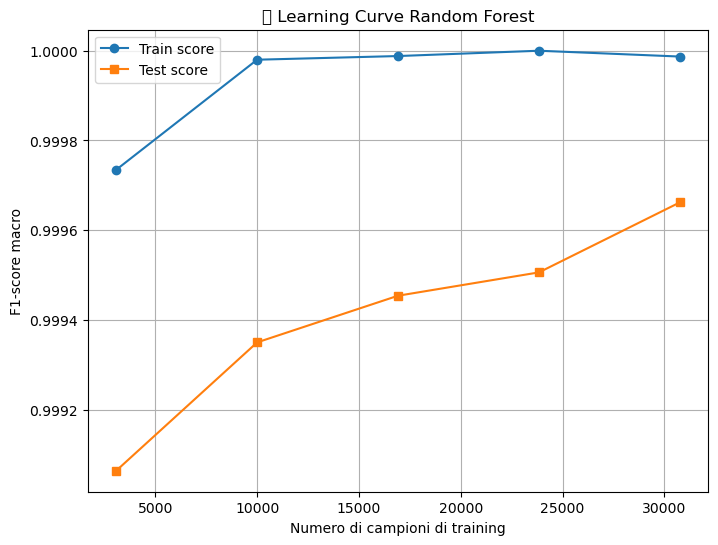


💡 Interpretazione Learning Curve:
- Gap elevato tra train e test → possibile OVERFITTING.
- Train e test vicini e alti → modello generalizza bene.
- Entrambi bassi → possibile UNDERFITTING.

📊 Generazione grafici e visualizzazioni...


<Figure size 800x600 with 0 Axes>

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


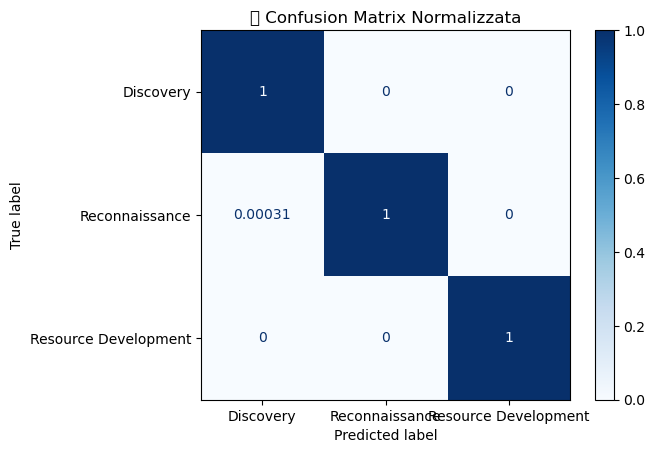

💡 Interpretazione: valori vicini a 1 sulla diagonale indicano buona capacità predittiva per ogni classe.


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


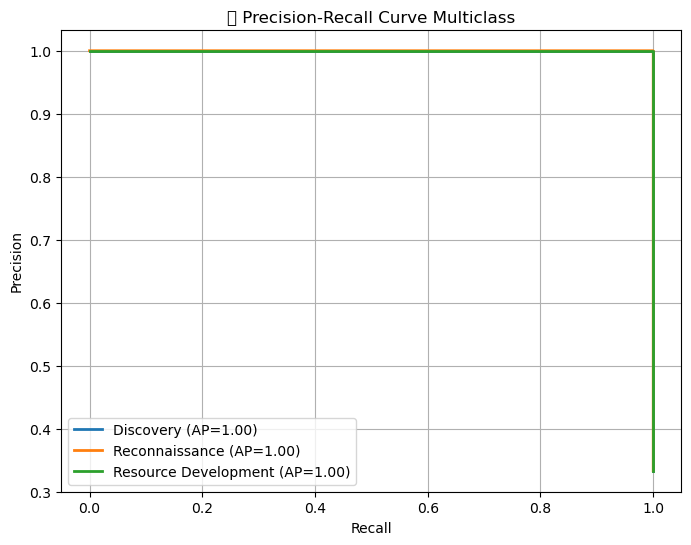

💡 Interpretazione: curve vicine all'angolo in alto a destra → buone performance; gap tra classi → sbilanciamento o difficoltà su alcune classi.


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


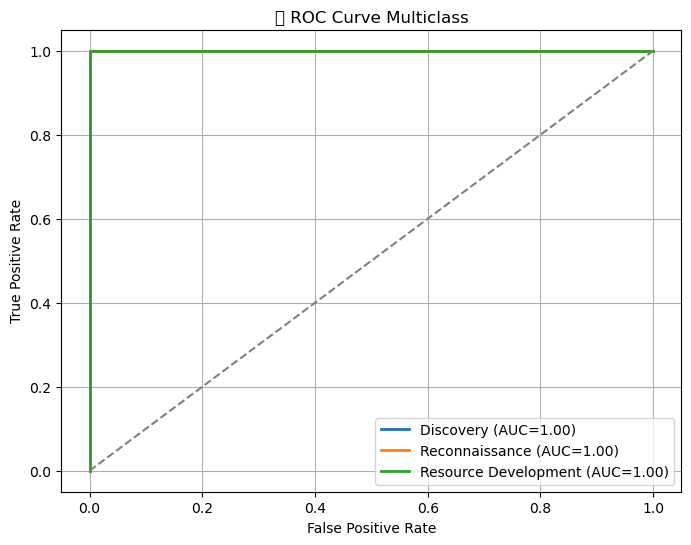

💡 Interpretazione: AUC vicino a 1 indica ottima capacità discriminativa; valori bassi → difficoltà nel distinguere classi.
✅ Tutti i grafici e metriche generati con successo.


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


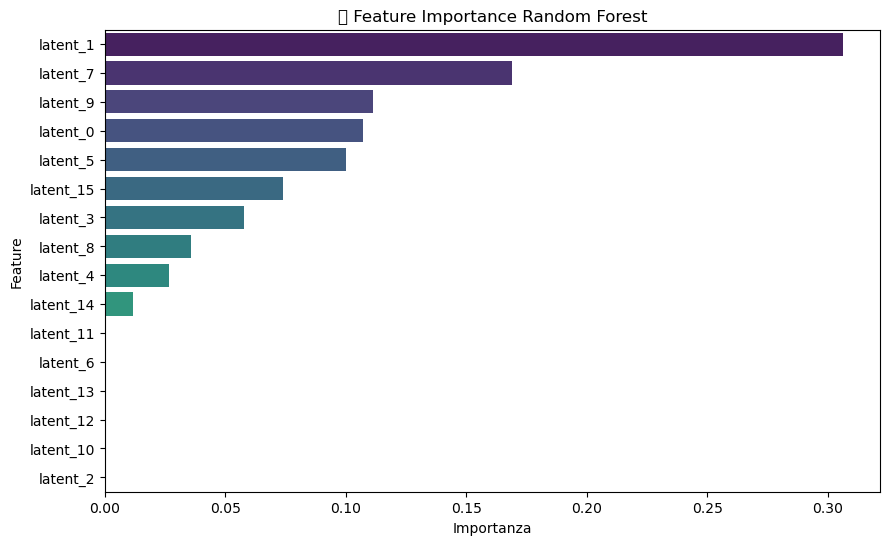

In [4]:
# ==========================================================
# BLOCCO 2: Random Forest con CV, metriche train vs test, learning curve e valutazione overfitting
# ==========================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("🏗️ Addestramento Random Forest con 5-fold CV e GridSearch (parametri moderati)...")

# 1️⃣ Modello base
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

# 2️⃣ GridSearchCV con parametri conservativi per evitare overfitting
param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 3️⃣ Fit su train set
grid_search.fit(X_train, y_train)

# 4️⃣ Miglior modello
best_rf = grid_search.best_estimator_
print(f"\n🏆 Miglior combinazione iperparametri: {grid_search.best_params_}")

# 5️⃣ Predizioni su train e test set
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# 6️⃣ Metriche sul train set
train_acc = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='macro')
train_recall = recall_score(y_train, y_train_pred, average='macro')
train_f1 = f1_score(y_train, y_train_pred, average='macro')

print("\n📊 Metriche sul TRAIN set:")
print(f"Accuracy:  {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-score:  {train_f1:.4f}")

# 7️⃣ Metriche sul test set
test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

cm = confusion_matrix(y_test, y_test_pred)
specificity = cm.diagonal() / (cm.sum(axis=1) - cm.diagonal() + cm.diagonal())

print("\n📊 Metriche sul TEST set:")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-score:  {test_f1:.4f}")
for i, cls in enumerate(best_rf.classes_):
    print(f"Specificity classe '{cls}': {specificity[i]:.4f}")

# 8️⃣ Valutazione automatica overfitting / underfitting
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")

# ==========================================================
# Learning Curve train vs test
# ==========================================================
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Train score", marker='o')
plt.plot(train_sizes, test_mean, label="Test score", marker='s')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve Random Forest")
plt.legend()
plt.grid(True)
plt.show()

print("""
💡 Interpretazione Learning Curve:
- Gap elevato tra train e test → possibile OVERFITTING.
- Train e test vicini e alti → modello generalizza bene.
- Entrambi bassi → possibile UNDERFITTING.
""")

# ==========================================================
# Grafici e metriche visuali
# ==========================================================
print("📊 Generazione grafici e visualizzazioni...")

# 1️⃣ Confusion Matrix
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Blues', normalize='true')
plt.title("📊 Confusion Matrix Normalizzata")
plt.show()
print("💡 Interpretazione: valori vicini a 1 sulla diagonale indicano buona capacità predittiva per ogni classe.")

# 2️⃣ Precision-Recall Curve Multiclass
y_test_bin = label_binarize(y_test, classes=best_rf.classes_)
y_score = best_rf.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, cls in enumerate(best_rf.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve Multiclass")
plt.legend()
plt.grid(True)
plt.show()
print("💡 Interpretazione: curve vicine all'angolo in alto a destra → buone performance; gap tra classi → sbilanciamento o difficoltà su alcune classi.")

# 3️⃣ ROC Curve Multiclass
plt.figure(figsize=(8,6))
for i, cls in enumerate(best_rf.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass")
plt.legend()
plt.grid(True)
plt.show()
print("💡 Interpretazione: AUC vicino a 1 indica ottima capacità discriminativa; valori bassi → difficoltà nel distinguere classi.")

print("✅ Tutti i grafici e metriche generati con successo.")

# Feature Importance RF
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]  # ordina decrescente

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices],
    y=X_train.columns[indices],
    palette="viridis"
)
plt.title("🌟 Feature Importance Random Forest")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()



🏗️ Addestramento MLPClassifier con 5-fold CV e parametri standard...

📊 Metriche sul TRAIN set:
Accuracy:  0.9995
Precision: 0.9995
Recall:    0.9995
F1-score:  0.9995

📊 Metriche sul TEST set:
Accuracy:  0.9995
Precision: 0.9995
Recall:    0.9995
F1-score:  0.9995
Specificity classe 'Discovery': 1.0000
Specificity classe 'Reconnaissance': 0.9991
Specificity classe 'Resource Development': 0.9994

✅ Modello bilanciato, nessun evidente overfitting/underfitting


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


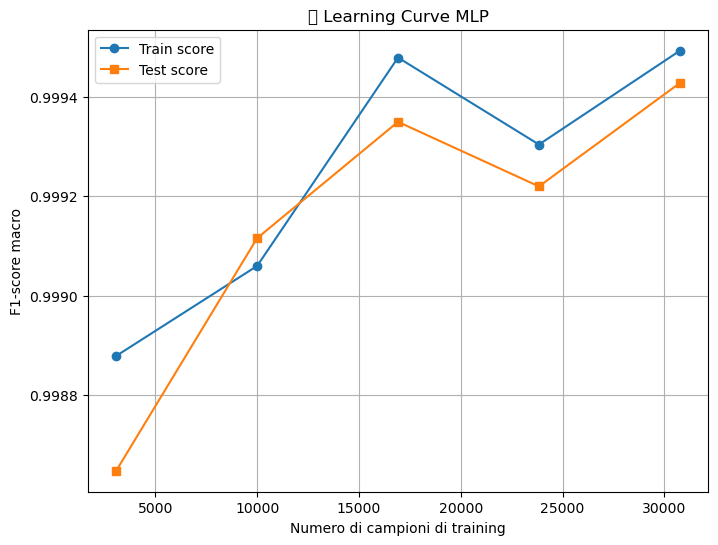

📊 Generazione grafici e visualizzazioni...


<Figure size 800x600 with 0 Axes>

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


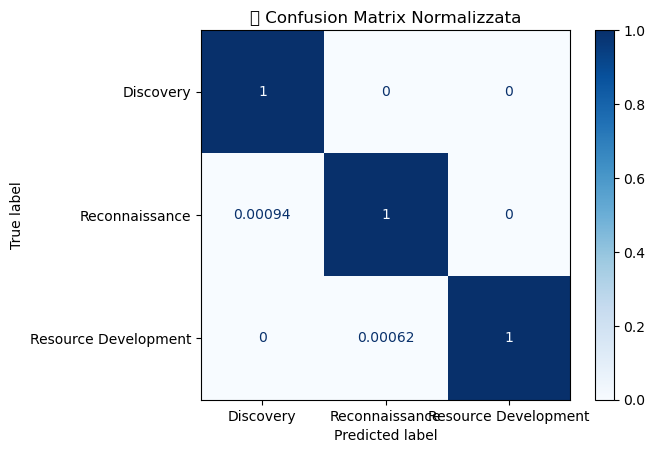

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


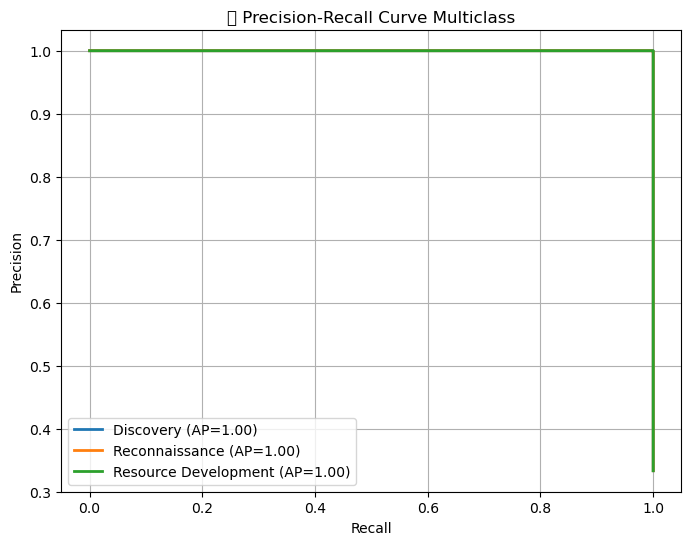

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


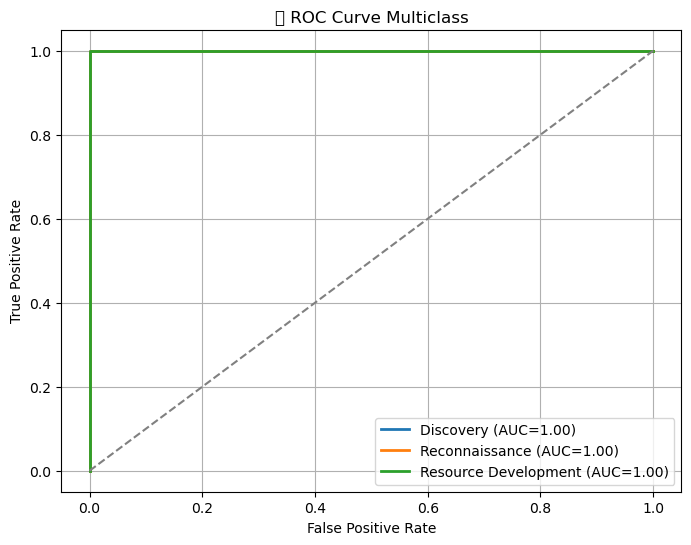

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


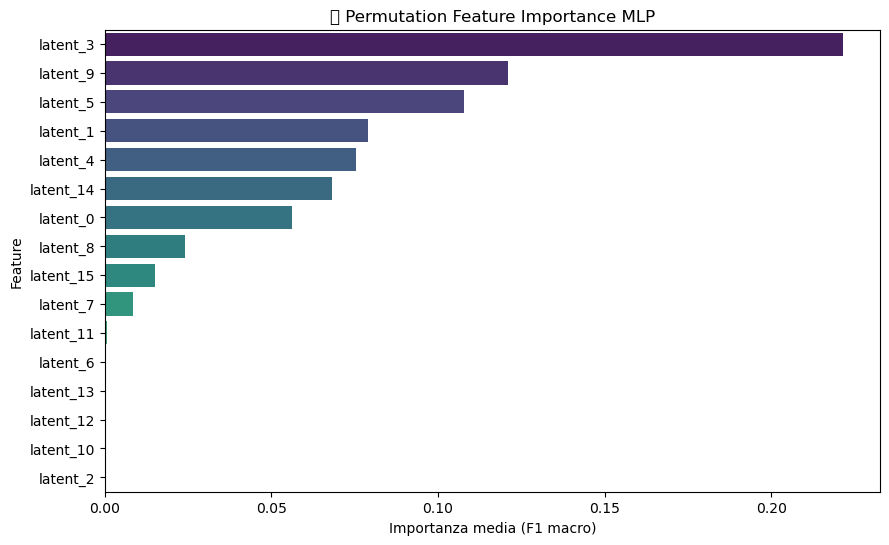

In [5]:
# ==========================================================
# BLOCCO MLP: Metriche train vs test, learning curve e visualizzazioni
# ==========================================================
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("🏗️ Addestramento MLPClassifier con 5-fold CV e parametri standard...")

# 1️⃣ MLP base
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=32,
    max_iter=500,
    early_stopping=True,
    random_state=42
)

# 2️⃣ Cross-validation stratificata (opzionale GridSearch per iperparametri)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3️⃣ Fit su train set
mlp.fit(X_train, y_train)

# 4️⃣ Predizioni su train e test set
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

# 5️⃣ Metriche sul train set
train_acc = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='macro')
train_recall = recall_score(y_train, y_train_pred, average='macro')
train_f1 = f1_score(y_train, y_train_pred, average='macro')

print("\n📊 Metriche sul TRAIN set:")
print(f"Accuracy:  {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-score:  {train_f1:.4f}")

# 6️⃣ Metriche sul test set
test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

cm = confusion_matrix(y_test, y_test_pred)
specificity = cm.diagonal() / (cm.sum(axis=1) - cm.diagonal() + cm.diagonal())

print("\n📊 Metriche sul TEST set:")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-score:  {test_f1:.4f}")
for i, cls in enumerate(mlp.classes_):
    print(f"Specificity classe '{cls}': {specificity[i]:.4f}")

# 7️⃣ Valutazione overfitting / underfitting
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")

# ==========================================================
# Learning Curve train vs test
# ==========================================================
train_sizes, train_scores, test_scores = learning_curve(
    mlp, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Train score", marker='o')
plt.plot(train_sizes, test_mean, label="Test score", marker='s')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve MLP")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# Grafici e metriche visuali
# ==========================================================
print("📊 Generazione grafici e visualizzazioni...")

# 1️⃣ Confusion Matrix
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test, cmap='Blues', normalize='true')
plt.title("📊 Confusion Matrix Normalizzata")
plt.show()

# 2️⃣ Precision-Recall Curve Multiclass
y_test_bin = label_binarize(y_test, classes=mlp.classes_)
y_score = mlp.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, cls in enumerate(mlp.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve Multiclass")
plt.legend()
plt.grid(True)
plt.show()

# 3️⃣ ROC Curve Multiclass
plt.figure(figsize=(8,6))
for i, cls in enumerate(mlp.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# Permutation Feature Importance MLP
# ==========================================================
perm_importance = permutation_importance(
    mlp, X_test, y_test, n_repeats=10, random_state=42, scoring='f1_macro'
)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10,6))
sns.barplot(
    x=perm_importance.importances_mean[sorted_idx],
    y=X_train.columns[sorted_idx],
    palette="viridis"
)
plt.title("🌟 Permutation Feature Importance MLP")
plt.xlabel("Importanza media (F1 macro)")
plt.ylabel("Feature")
plt.show()


🏗️ Addestramento LightGBM con 5-fold CV e GridSearch (parametri moderati)...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 38448, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


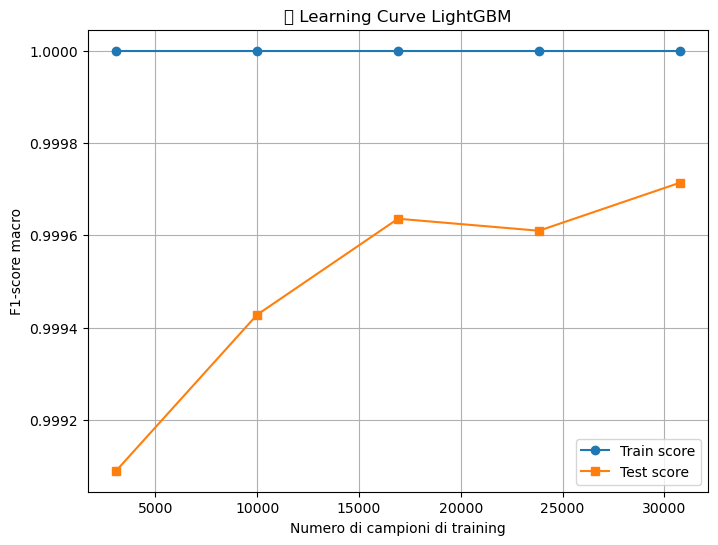

<Figure size 800x600 with 0 Axes>

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


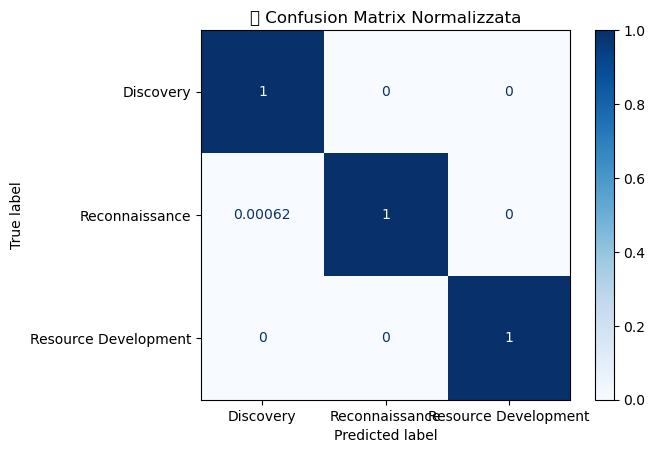

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


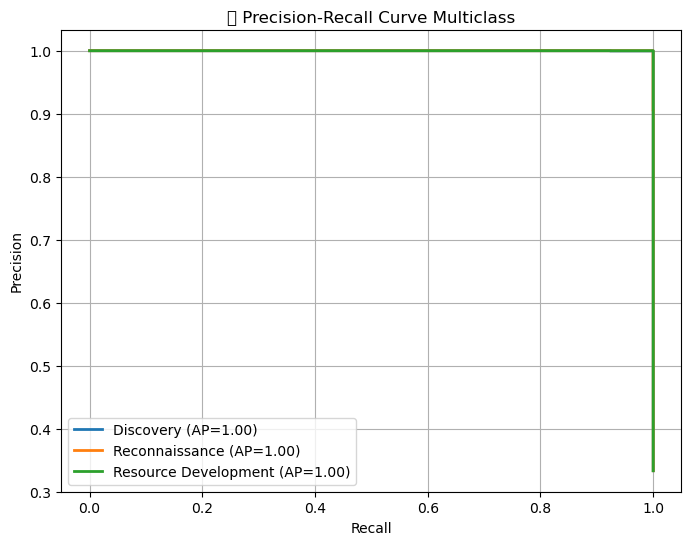

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


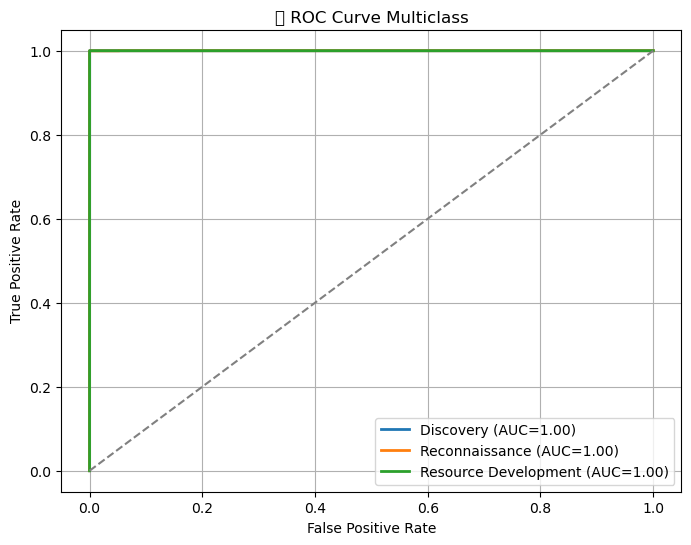

c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


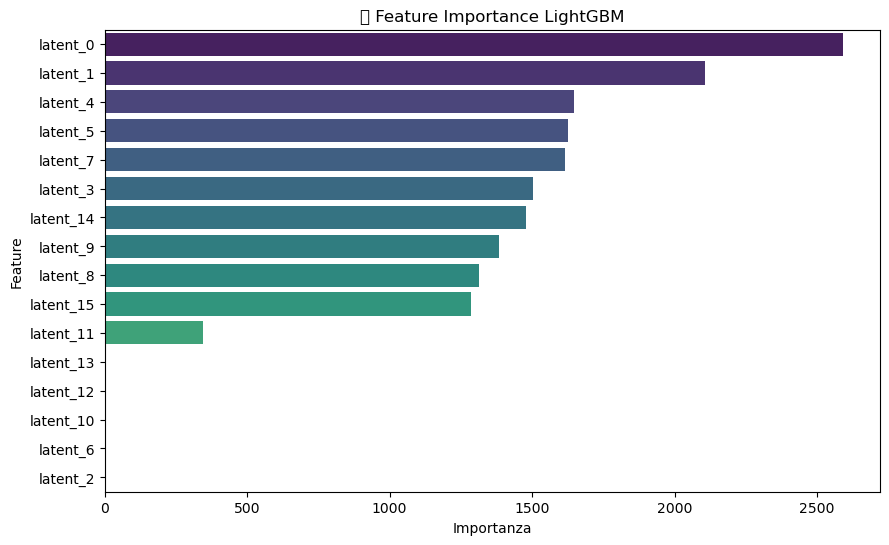

In [6]:
# ==========================================================
# BLOCCO LightGBM con CV, metriche train vs test, learning curve
# ==========================================================
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
    ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("🏗️ Addestramento LightGBM con 5-fold CV e GridSearch (parametri moderati)...")

# 1️⃣ Modello base
lgb_clf = lgb.LGBMClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# 2️⃣ GridSearchCV per iperparametri conservativi
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# 3️⃣ Fit su train set
grid_search.fit(X_train, y_train)

# 4️⃣ Miglior modello
best_lgb = grid_search.best_estimator_
print(f"\n🏆 Miglior combinazione iperparametri: {grid_search.best_params_}")

# 5️⃣ Predizioni su train e test set
y_train_pred = best_lgb.predict(X_train)
y_test_pred = best_lgb.predict(X_test)

# 6️⃣ Metriche sul train set
train_acc = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='macro')
train_recall = recall_score(y_train, y_train_pred, average='macro')
train_f1 = f1_score(y_train, y_train_pred, average='macro')

print("\n📊 Metriche sul TRAIN set:")
print(f"Accuracy:  {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-score:  {train_f1:.4f}")

# 7️⃣ Metriche sul test set
test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

cm = confusion_matrix(y_test, y_test_pred)
specificity = cm.diagonal() / (cm.sum(axis=1) - cm.diagonal() + cm.diagonal())

print("\n📊 Metriche sul TEST set:")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-score:  {test_f1:.4f}")
for i, cls in enumerate(best_lgb.classes_):
    print(f"Specificity classe '{cls}': {specificity[i]:.4f}")

# 8️⃣ Valutazione over/underfitting
gap_f1 = train_f1 - test_f1
if gap_f1 > 0.05:
    print(f"\n⚠️ Possibile OVERFITTING: gap F1 train-test = {gap_f1:.4f}")
elif test_f1 < 0.7:
    print(f"\n⚠️ Possibile UNDERFITTING: F1 test = {test_f1:.4f}")
else:
    print("\n✅ Modello bilanciato, nessun evidente overfitting/underfitting")

# ==========================================================
# Learning Curve train vs test
# ==========================================================
train_sizes, train_scores, test_scores = learning_curve(
    best_lgb, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Train score", marker='o')
plt.plot(train_sizes, test_mean, label="Test score", marker='s')
plt.xlabel("Numero di campioni di training")
plt.ylabel("F1-score macro")
plt.title("📈 Learning Curve LightGBM")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# Confusion Matrix
# ==========================================================
plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_estimator(best_lgb, X_test, y_test, cmap='Blues', normalize='true')
plt.title("📊 Confusion Matrix Normalizzata")
plt.show()

# ==========================================================
# Precision-Recall Curve Multiclass
# ==========================================================
y_test_bin = label_binarize(y_test, classes=best_lgb.classes_)
y_score = best_lgb.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, cls in enumerate(best_lgb.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Precision-Recall Curve Multiclass")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# ROC Curve Multiclass
# ==========================================================
plt.figure(figsize=(8,6))
for i, cls in enumerate(best_lgb.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Multiclass")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================================
# Feature Importance
# ==========================================================
importances = best_lgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=X_train.columns[indices], palette="viridis")
plt.title("🌟 Feature Importance LightGBM")
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.show()
